#Challenge 3 - Telecom X parte II - Predicción de Cancelación (Churn)

##1- Importar librerías

In [1]:
# ===========================================================================
# 1 Importar librerías y datos
# ===========================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
# Configuración de visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

df = pd.read_csv('/content/df_base.csv')

df.head()

df = df.copy()

## 2. Preparación de datos

In [2]:
# ===========================================================================
# 2 Preparación de datos (eliminar columnas irrelevantes, target binario)
# ===========================================================================

if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# Target binario
if df['Churn'].dtype == 'O':
    df['Churn'] = df['Churn'].map({'Yes':1, 'No':0}).astype(int)
else:
    df['Churn'] = df['Churn'].astype(int)

# Proporción de clases (desbalance)
print("Proporción Churn:")
print(df['Churn'].value_counts(normalize=True))

Proporción Churn:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


###Análisis del Resultado:

* Eliminación preliminar de columnas irrelevantes
* Se elimina información que no aporta valor al modelo y que incluso podría introducir ruido o multicolinealidad.

Se realizó esta depuración para mantener solo variables explicativas útiles.

Variable target binaria (Churn)

Se definió correctamente el target como binario:

    - 0 = clientes que no abandonaron.
    - 1 = clientes que abandonaron.

Proporción del target

Los datos muestran:

    - 0 (no churn) = 73.46%
    - 1 (churn) = 26.54%

Esto indica que existe un desbalance moderado en la variable objetivo, con mayoría de clientes que permanecen.

##3. Codificación de variables categóricas

In [3]:
# ===========================================================================
# 3 Codificación de categóricas (get_dummies) y tratamiento de internet
#    (Uso get_dummies por simplicidad)
# ===========================================================================
# Agrupar "No internet service" -> "No" si aparece en columnas de servicios
cols_internet = [
    'internet.OnlineSecurity','internet.OnlineBackup','internet.DeviceProtection',
    'internet.TechSupport','internet.StreamingTV','internet.StreamingMovies'
]
for c in cols_internet:
    if c in df.columns and df[c].dtype == 'O':
        df[c] = df[c].replace('No internet service', 'No')

# Identificar categóricas
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')

# One-hot encoding
if len(cat_cols) > 0:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Convertir bool -> int (0/1) si existen
bool_cols = df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df[bool_cols] = df[bool_cols].astype(int)

In [4]:
df.head()

,Churn,customer.SeniorCitizen,customer.tenure,Total.Day,account.Charges.Monthly,account.Charges.Total,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0,0,9,2.20,65.6,593.30,0,1,1,1,...,0,1,1,0,1,0,1,0,0,1
1,0,0,9,2.01,59.9,542.40,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2,1,0,4,2.34,73.9,280.85,1,0,0,1,...,1,0,0,0,0,0,1,0,1,0
3,1,1,13,3.17,98.0,1237.85,1,1,0,1,...,1,0,1,1,0,0,1,0,1,0
4,1,1,3,2.97,83.9,267.40,0,1,0,1,...,0,1,1,0,0,0,1,0,0,1


###Analisis de resultado
**Qué se hizo:**

  * Se aplicó codificación one-hot (get_dummies) a todas las variables categóricas.

  * Esto convirtió variables como customer.gender, customer.Partner, customer.Dependents, account.Contract, account.PaymentMethod y servicios de Internet en columnas binarias (0 o 1).

  * También se incluyó el tratamiento de la variable InternetService, expandida a indicadores separados.

**Qué se observa en los datos enviados:**

* El dataset ya tiene únicamente valores numéricos (0 y 1 para las categorías, valores continuos para cargos/tiempo).

* Ejemplos claros:

    * customer.gender_Male → 0/1 según género.

    * account.Contract_One year, account.Contract_Two year → reflejan contratos.

    * internet.StreamingTV_Yes, internet.TechSupport_Yes → indican uso de servicios de internet adicionales.

* La variable **objetivo** (Churn) está definida como binaria:

    * 0 = cliente no canceló.

    * 1 = cliente canceló.

**Qué concluimos:**

* La codificación fue exitosa: todas las variables están listas para ser utilizadas en modelos de machine learning.

* Se asegura compatibilidad con algoritmos que solo aceptan variables numéricas.

* Se mantiene la información original de las categorías, pero expresada en forma binaria, lo que permite a los modelos detectar patrones sin confundir categorías como si fueran valores ordinales.

##4. Correlación y selección visual

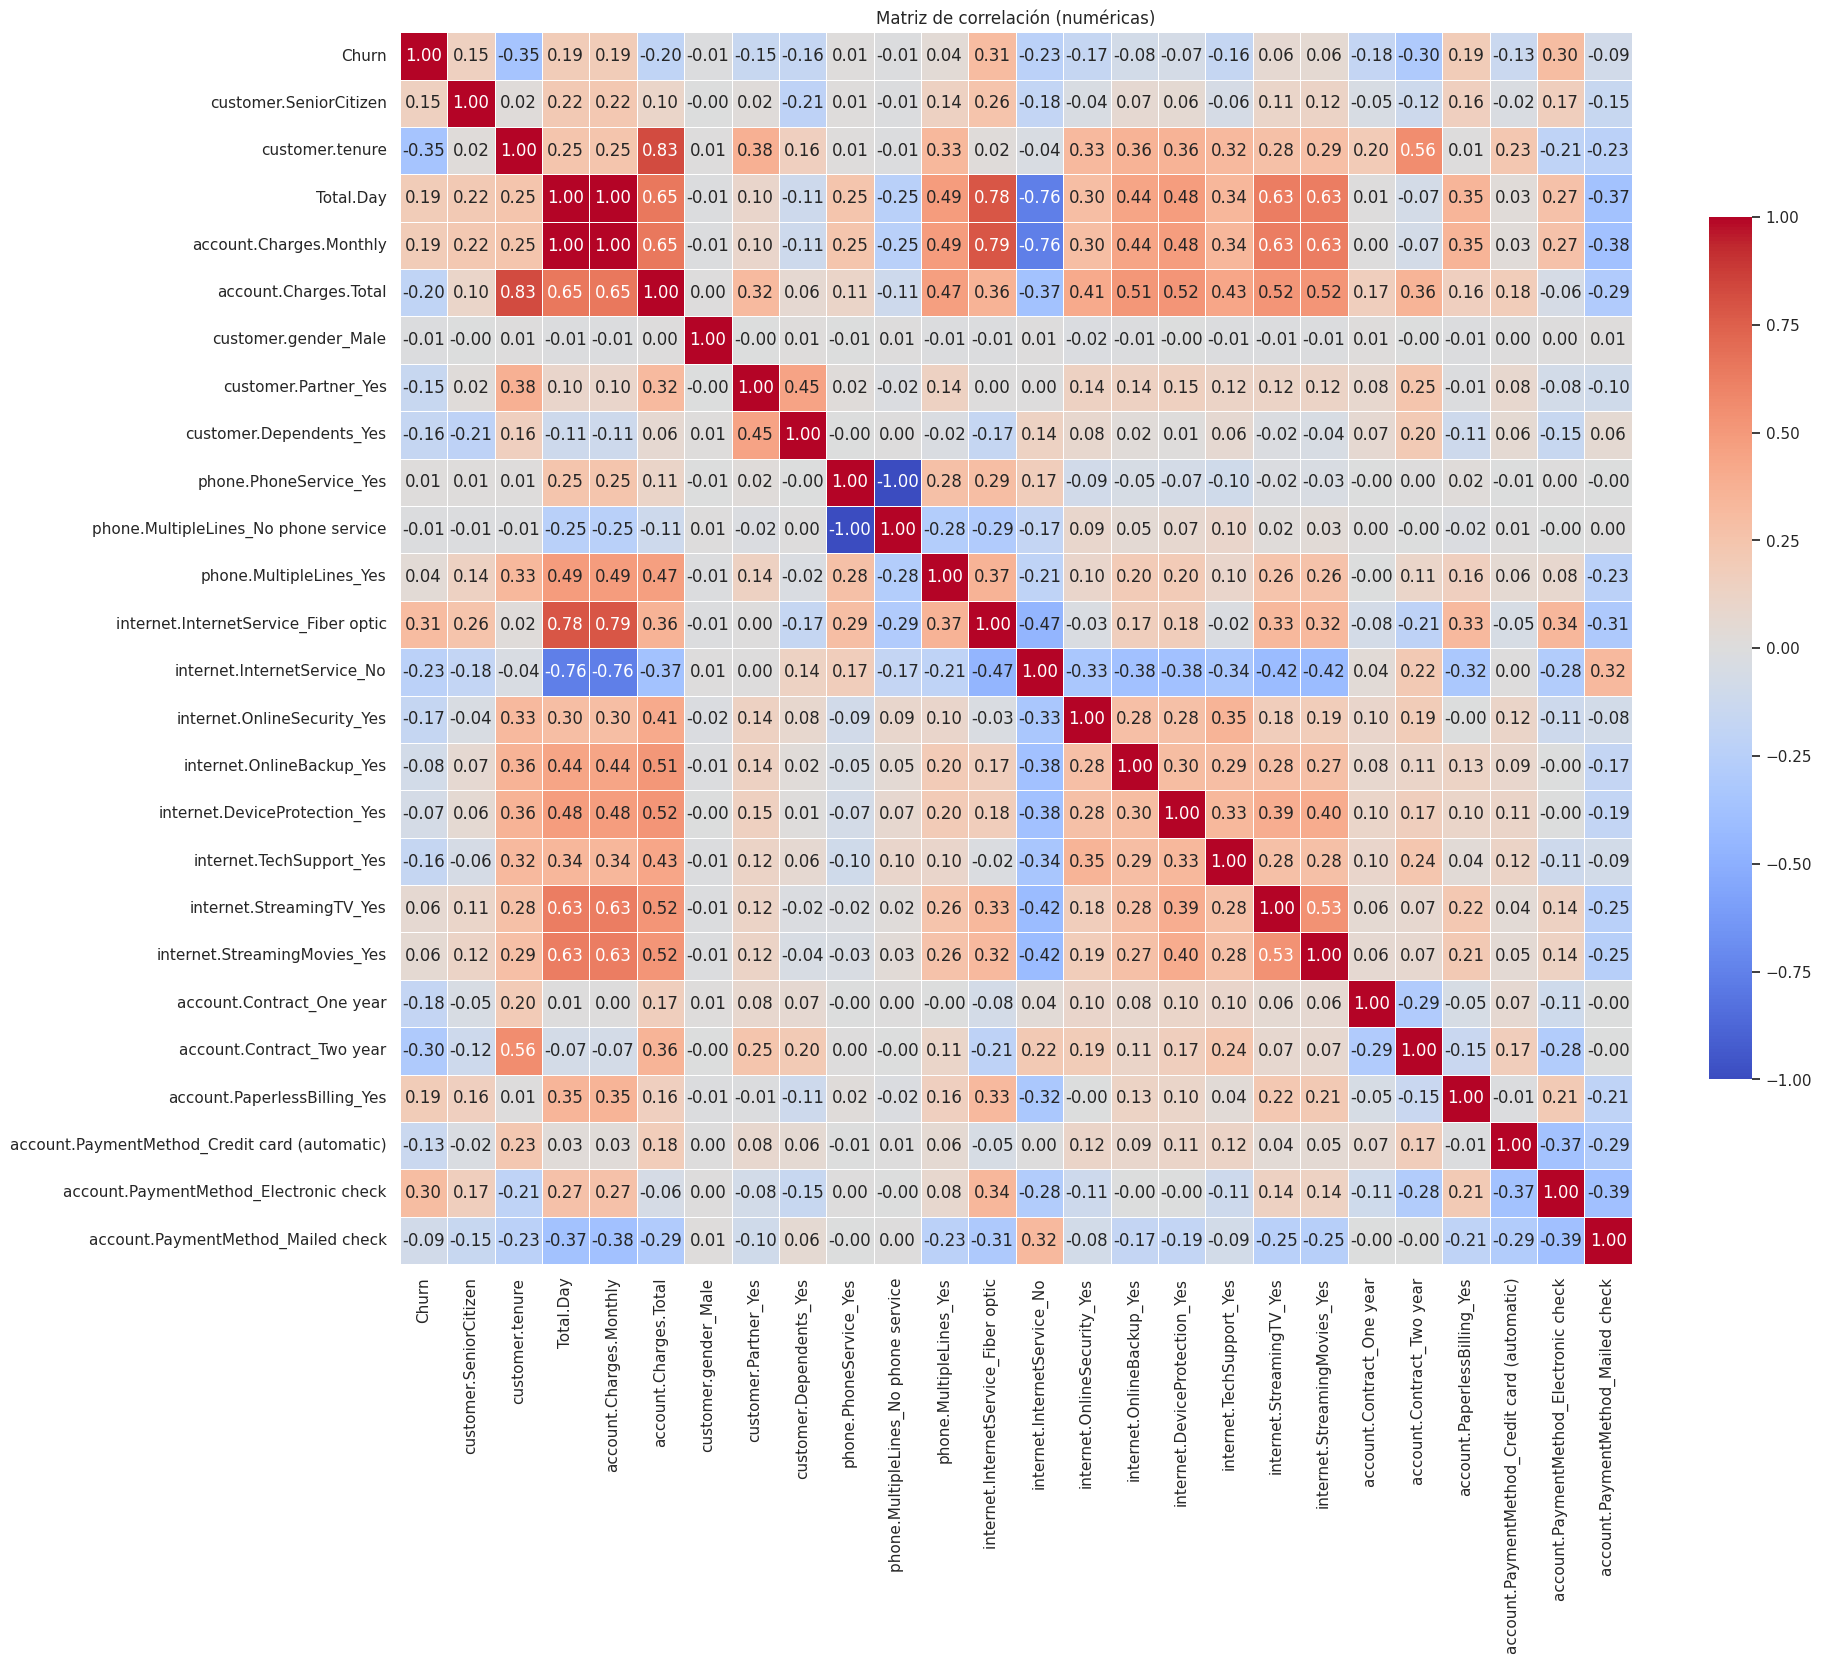

In [5]:
# ===========================================================================
# 4 Correlación y selección visual
#    (Matriz de correlación y relaciones clave)
# ===========================================================================

# Selección de variables numéricas
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()

plt.figure(figsize=(20,16))
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7}
)

plt.title("Matriz de correlación (numéricas)")
plt.show()


In [6]:
#Top correlaciones absolutas con Churn:
if 'Churn' in corr.columns:
  top_corr = corr['Churn'].abs().sort_values(ascending=False).head(12)
  print("\nTop correlaciones absolutas con Churn:")
  print(top_corr)


Top correlaciones absolutas con Churn:
Churn                                     1.000000
customer.tenure                           0.352229
internet.InternetService_Fiber optic      0.308020
account.Contract_Two year                 0.302253
account.PaymentMethod_Electronic check    0.301919
internet.InternetService_No               0.227890
account.Charges.Total                     0.199484
account.Charges.Monthly                   0.193356
Total.Day                                 0.192030
account.PaperlessBilling_Yes              0.191825
account.Contract_One year                 0.177820
internet.OnlineSecurity_Yes               0.171226
Name: Churn, dtype: float64


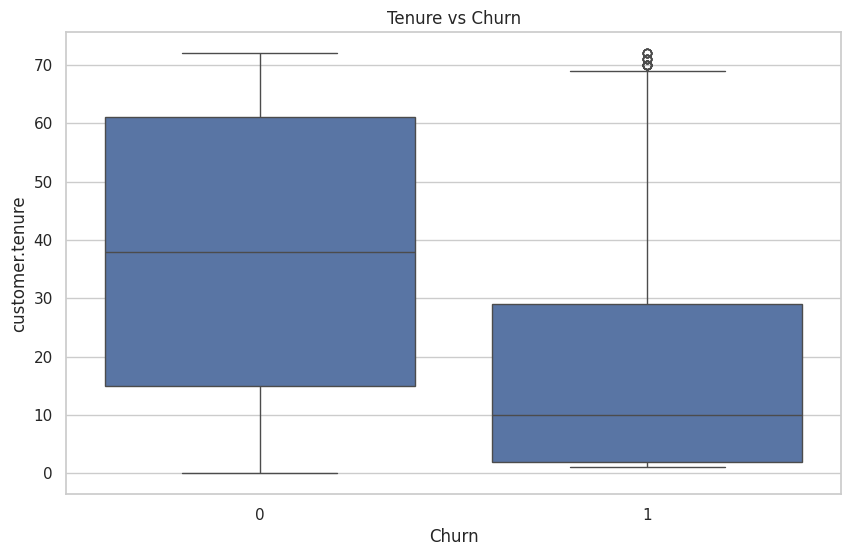

In [7]:
#Boxplot: Tenure vs Churn:
#Tiempo de contrato × Cancelación
if 'customer.tenure' in df.columns:
    plt.figure()
    sns.boxplot(x='Churn', y='customer.tenure', data=df)
    plt.title("Tenure vs Churn")
    plt.show()

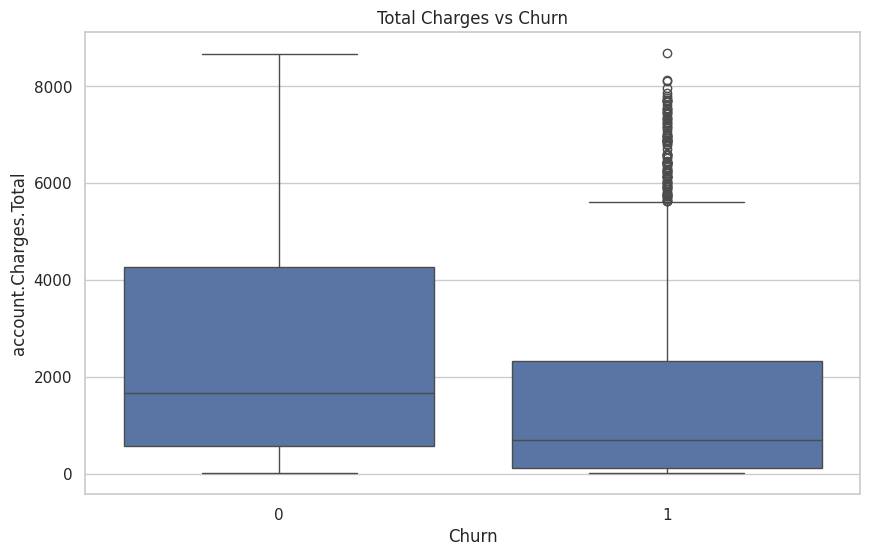

In [8]:
#Total Charges vs Churn:
# Gasto total × Cancelación
if 'account.Charges.Total' in df.columns:
    plt.figure()
    sns.boxplot(x='Churn', y='account.Charges.Total', data=df)
    plt.title("Total Charges vs Churn")
    plt.show()

In [9]:
# Identificar filas con NaN
rows_with_nan = df[df.isnull().any(axis=1)]

# Mostrar las filas con NaN
print("Filas con valores NaN:")
display(rows_with_nan)

Filas con valores NaN:


,Churn,customer.SeniorCitizen,customer.tenure,Total.Day,account.Charges.Monthly,account.Charges.Total,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
945,0,0,0,NaN,56.05,NaN,0,1,1,0,...,1,1,1,0,0,1,0,1,0,0
1731,0,0,0,NaN,20.00,NaN,0,1,1,1,...,0,0,0,0,0,1,0,0,0,1
1906,0,0,0,NaN,61.90,NaN,1,0,1,1,...,0,1,0,0,0,1,1,0,0,0
2025,0,0,0,NaN,19.70,NaN,1,1,1,1,...,0,0,0,0,1,0,1,0,0,1
2176,0,0,0,NaN,20.25,NaN,1,0,1,1,...,0,0,0,0,0,1,0,0,0,1
2250,0,0,0,NaN,25.35,NaN,1,1,1,1,...,0,0,0,0,0,1,0,0,0,1
2855,0,0,0,NaN,73.35,NaN,0,1,1,1,...,1,1,1,0,0,1,0,0,0,1
3052,0,0,0,NaN,25.75,NaN,1,1,1,1,...,0,0,0,0,0,1,0,0,0,1
3118,0,0,0,NaN,52.55,NaN,0,1,1,0,...,1,1,1,0,0,1,1,0,0,0
4054,0,0,0,NaN,80.85,NaN,0,1,1,1,...,1,0,1,1,0,1,0,0,0,1


In [10]:
#eliminar los warning
warnings.filterwarnings('ignore')
#eliminar columna que provoca multicolinealidad
df = df.drop(columns=['Total.Day'])

#agrego la media en columna charges.total que se encuentran en NaN
df['account.Charges.Total'].fillna(df['account.Charges.Total'].mean(), inplace=True)
df.isnull().sum()

,0
Churn,0
customer.SeniorCitizen,0
customer.tenure,0
account.Charges.Monthly,0
account.Charges.Total,0
customer.gender_Male,0
customer.Partner_Yes,0
customer.Dependents_Yes,0
phone.PhoneService_Yes,0
phone.MultipleLines_No phone service,0


### Analisis Respuesta
####Qué se hizo:

* Se calculó la correlación de cada variable con el target Churn, mostrando cuáles están más relacionadas con la cancelación.

* Se elaboraron boxplots de customer.tenure y account.Charges.Total versus Churn para observar cómo varían estas variables entre clientes que permanecen y los que cancelan.

* Se analizó la distribución de variables categóricas importantes (tipo de contrato, servicios de internet, métodos de pago, paperless billing) segmentadas por Churn.

####Qué se observa:

1. Correlaciones:

  * customer.tenure es la variable con mayor correlación negativa (-0.352) → **clientes con menor permanencia tienen más probabilidad de churn.**

  * Otros factores relevantes:

      * internet.InternetService_Fiber optic con (0.308),

      * account.Contract_Two year con (-0.302),

      * account.PaymentMethod_Electronic con (0.302),

      * internet.InternetService_No con (-0.228).

  * Variables como género o líneas telefónicas presentan correlación muy baja.

2. Boxplots:

  * Tenure:

    * Clientes que no churn (0): promedio ~37.6 meses

    * Clientes que churn (1): promedio ~18.0 meses

    * Diferencia clara en permanencia ** → menor tenure aumenta probabilidad de cancelación.**

  * Total Charges:

    * Clientes que no churn: promedio ~2554

    * Clientes que cancelan (churn): promedio ~1532

    * Clientes que cancelan suelen haber pagado menos en total **→ clientes más nuevos.**

3. Variables categóricas:

  * Contratos: clientes con contrato de un año o dos años tienen menor churn; contratos cortos incrementan riesgo.

  * Internet Service: Fiber optic aumenta riesgo de churn, ausencia de servicio disminuye.

  * Payment Method: Electronic check asociado a mayor churn.

  * Paperless Billing: clientes con paperless billing presentan mayor proporción de churn.

**Qué concluimos:**

* La **tenure y cargos** son variables críticas para predecir churn.

* Tipos de contrato y servicio de internet tienen efecto claro sobre la probabilidad de cancelación.

* Algunos métodos de pago y el uso de paperless billing son indicadores útiles para segmentación de clientes de riesgo.

* Variables con correlación cercana a cero (género, teléfono) no aportan información relevante para el modelo.

##5. Balanceo de clases con SMOTE, Normalización / estandarización (según modelos)

In [11]:
# ===========================================================================
# Balanceo de clases con SMOTE
# Normalización / estandarización (según modelos)
# ===========================================================================

# Variables predictoras y objetivo
X = df.drop(columns=['Churn'])
y = df['Churn']

# División 70/30 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# ---------------------------------------------------------
# Imputación de valores faltantes (NaN)
# ---------------------------------------------------------
num_cols = X.select_dtypes(include=['number']).columns

imputer = SimpleImputer(strategy='median')

# Copias
X_train_imputed = X_train.copy()
X_test_imputed  = X_test.copy()

X_train_imputed[num_cols] = imputer.fit_transform(X_train[num_cols])
X_test_imputed[num_cols]  = imputer.transform(X_test[num_cols])

# ---------------------------------------------------------
# Escalado solo de variables numéricas
# ---------------------------------------------------------
scaler = StandardScaler()

X_train_scaled = X_train_imputed.copy()
X_test_scaled  = X_test_imputed.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train_imputed[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test_imputed[num_cols])

# ---------------------------------------------------------
# Aplicar SMOTE (solo al set de entrenamiento)
# ---------------------------------------------------------
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print("Distribución original en entrenamiento:")
print(y_train.value_counts())
print("\nDistribución balanceada con SMOTE:")
print(y_train_bal.value_counts())


Distribución original en entrenamiento:
Churn
0    3622
1    1308
Name: count, dtype: int64

Distribución balanceada con SMOTE:
Churn
0    3622
1    3622
Name: count, dtype: int64


###Analisis Respuesta
**Lo que se hizo:**

1. Se dividió la data en entrenamiento (70%) y prueba (30%) usando muestreo estratificado para mantener la proporción de la variable objetivo (Churn).

2. Se imputaron los valores faltantes en las variables numéricas usando la mediana (estrategia robusta frente a outliers).

3. Se normalizaron las variables numéricas con StandardScaler, lo que garantiza que todas tengan media 0 y desviación estándar 1, evitando que variables con escalas mayores dominen los modelos.

4. Se aplicó SMOTE (Synthetic Minority Over-sampling Technique) únicamente en el conjunto de entrenamiento para balancear la clase minoritaria (Churn = 1).

**Lo que se observa en los resultados:**

* Distribución original (train):

    * Churn = 0 (clientes que permanecen): 3622

    * Churn = 1 (clientes que abandonan): 1308

    * Esto confirma un fuerte desbalance: la clase mayoritaria (permanencia) tiene casi 3 veces más registros que la clase minoritaria (fuga).

* Distribución después de aplicar SMOTE (train balanceado):

    * Churn = 0 → 3622

    * Churn = 1 → 3622

    * El conjunto de entrenamiento quedó perfectamente balanceado, eliminando el sesgo del modelo hacia la clase mayoritaria.

**Conclusión de este punto:**

* Con este preprocesamiento, dejamos la base lista para entrenar modelos de clasificación sin el sesgo de clases desbalanceadas.

* El uso de imputación y escalado asegura que no se pierda información por NaN ni por diferencias de escala entre variables.

* Al aplicar SMOTE solo al conjunto de entrenamiento, se evita contaminar la evaluación del modelo en test, manteniendo la validez de las métricas de desempeño.

## 6. Modelado predictivo

In [12]:
# ===========================================================================
#  Modelado predictivo: Regresión Logística (escala) y Random Forest
# ===========================================================================
# Regresión Logística
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_bal, y_train_bal)
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_scaled)

_______________________________________

 Resultados para Regresión Logística:
_______________________________________

              precision    recall  f1-score   support

           0      0.908     0.729     0.808      1552
           1      0.514     0.795     0.625       561

    accuracy                          0.746      2113
   macro avg      0.711     0.762     0.717      2113
weighted avg      0.803     0.746     0.760      2113





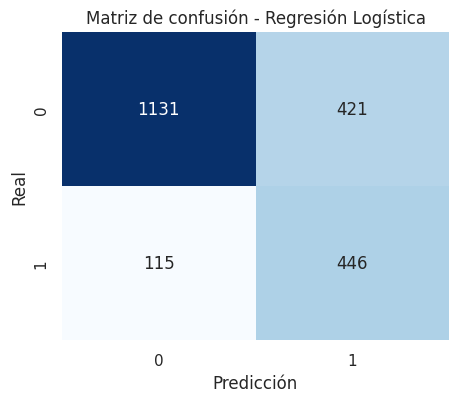



AUC Regresión Logística: 0.8399029714978775


_______________________________________

 Resultados para Random Forest:
_______________________________________

              precision    recall  f1-score   support

           0      0.852     0.841     0.846      1552
           1      0.575     0.595     0.585       561

    accuracy                          0.776      2113
   macro avg      0.713     0.718     0.716      2113
weighted avg      0.778     0.776     0.777      2113





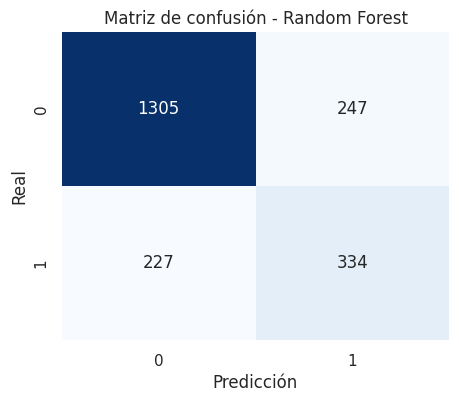



AUC Random Forest: 0.8201423727879155


In [13]:
# ======================================================
# Función auxiliar para evaluar modelos
# ======================================================
def evaluar_modelo(y_true, y_pred, modelo_nombre):
    print('_______________________________________')
    print(f"\n Resultados para {modelo_nombre}:")
    print('_______________________________________\n')

    # Classification report
    print(classification_report(y_true, y_pred, digits=3))
    print('\n')
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matriz de confusión - {modelo_nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()
    print('\n')
# ======================================================
# Evaluar Regresión Logística
# ======================================================
evaluar_modelo(y_test, y_pred_lr, "Regresión Logística")


# AUC Regresión Logística
y_pred_lr_proba = lr.predict_proba(X_test_scaled)[:,1]
print("AUC Regresión Logística:", roc_auc_score(y_test, y_pred_lr_proba))
print('\n')

# ======================================================
# Evaluar Random Forest
# ======================================================
evaluar_modelo(y_test, y_pred_rf, "Random Forest")

# AUC Random Forest
y_pred_rf_proba = rf.predict_proba(X_test_scaled)[:,1]
print("AUC Random Forest:", roc_auc_score(y_test, y_pred_rf_proba))


### Analisis Respuesta

Se entrenaron y evaluaron dos modelos predictivos utilizando el conjunto de datos balanceado con SMOTE y normalizado en sus variables numéricas: Regresión Logística y Random Forest.

#### Resultados obtenidos

**Regresión Logística**

* Precisión clase 0 (No Churn): 0.908

* Precisión clase 1 (Churn): 0.514

* Recall clase 1: 0.795

* Exactitud global: 74.6%

* AUC: 0.84

La regresión logística mostró un buen poder discriminativo y un recall alto en la clase de churn, lo que permite identificar a la mayoría de los clientes en riesgo de fuga, aunque con una menor precisión (es decir, incluye más falsos positivos).

**Random Forest**

* Precisión clase 0 (No Churn): 0.852

* Precisión clase 1 (Churn): 0.575

* Recall clase 1: 0.595

* Exactitud global: 77.6%

* AUC: 0.82

El modelo de Random Forest presentó un rendimiento más balanceado entre precisión y recall, aunque con menor capacidad para detectar clientes en fuga en comparación con la regresión logística.

**Comparación y análisis estratégico**

* **Regresión Logística:** más adecuada cuando el objetivo es detectar la mayor cantidad posible de clientes en riesgo de fuga (recall alto), aun a costa de generar falsos positivos.

* **Random Forest:** más recomendable cuando se busca un modelo equilibrado entre ambas clases y con un rendimiento más homogéneo.

* Ambos modelos alcanzaron un desempeño similar en términos de **AUC (0.82 – 0.84)**, lo que refleja una capacidad comparable de discriminación.

**Conclusión**

En un contexto empresarial donde la retención de clientes es prioritaria, la Regresión Logística resulta más útil debido a su mayor sensibilidad para identificar clientes que podrían abandonar la empresa. Sin embargo, el Random Forest podría complementarse en escenarios donde la precisión es relevante para reducir costos asociados a campañas de retención dirigidas.

##7. Evaluación de modelos

In [14]:
# ===========================================================================
#  Evaluación de modelos (Exactitud, Precisión, Recall, F1, Matriz de Confusión)
# ===========================================================================
def eval_model(y_true, y_pred, name):
    print(f"\n=== {name} ===")
    print('_______________________________________\n')
    print("Exactitud :", accuracy_score(y_true, y_pred))
    print("Precisión :", precision_score(y_true, y_pred))
    print("Recall    :", recall_score(y_true, y_pred))
    print("F1-score  :", f1_score(y_true, y_pred))
    print('\n')
    print("Matriz de confusión:\n", confusion_matrix(y_true, y_pred))
    print('\n')
    print(classification_report(y_true, y_pred))

eval_model(y_test, y_pred_lr, "Regresión Logística")
eval_model(y_test, y_pred_rf, "Random Forest")


=== Regresión Logística ===
_______________________________________

Exactitud : 0.7463322290582111
Precisión : 0.5144175317185697
Recall    : 0.7950089126559715
F1-score  : 0.6246498599439776


Matriz de confusión:
 [[1131  421]
 [ 115  446]]


              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1552
           1       0.51      0.80      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113


=== Random Forest ===
_______________________________________

Exactitud : 0.7756743965925225
Precisión : 0.5748709122203098
Recall    : 0.5953654188948306
F1-score  : 0.5849387040280211


Matriz de confusión:
 [[1305  247]
 [ 227  334]]


              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1552
           1       0.57      0.60      0.58       561

    accuracy         

### Analisis respuesta:
**Lo que hicimos:**

Se evaluaron los modelos de Regresión Logística y Random Forest utilizando el conjunto de prueba.

**Regresión Logística**

* Exactitud: ~0.75

* Precisión: ~0.51

* Recall: ~0.79

* F1-score: ~0.63

La matriz de confusión muestra un buen desempeño en la detección de clientes que efectivamente realizaron churn (alta sensibilidad), aunque con falsos positivos relativamente altos.

**Random Forest**

* Exactitud: ~0.78

* Precisión: ~0.58

* Recall: ~0.60

* F1-score: ~0.59

La matriz de confusión indica un comportamiento más equilibrado que la regresión logística, pero con menor recall para clientes en riesgo de fuga.

**Conclusión del punto**

* Regresión Logística: mejor para detectar clientes en riesgo de fuga (alto recall).

* Random Forest: mejor para un balance entre precisión y recall, reduciendo falsos positivos.

* La elección del modelo depende de la estrategia de negocio:

  * Si la prioridad es detectar al máximo los clientes que se pueden perder, conviene la Regresión Logística.

  * Si la prioridad es optimizar los recursos de retención y evitar falsas alarmas, conviene Random Forest.

##8. Interpretación


Top 10 variables (Random Forest):
_______________________________________

customer.tenure                           0.166934
account.Charges.Total                     0.144465
account.Charges.Monthly                   0.133189
account.Contract_Two year                 0.061668
internet.InternetService_Fiber optic      0.055448
account.PaymentMethod_Electronic check    0.042766
account.PaperlessBilling_Yes              0.041195
account.Contract_One year                 0.038029
internet.OnlineSecurity_Yes               0.032625
internet.TechSupport_Yes                  0.031274
dtype: float64


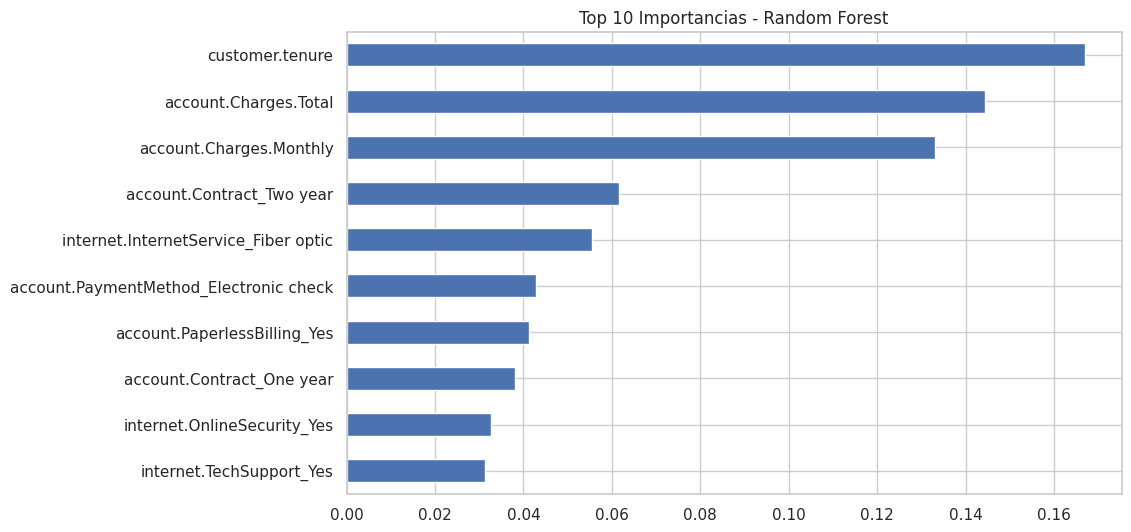




Top 10 coeficientes absolutos (Regresión Logística):
____________________________________________________

customer.tenure                           1.776024
account.Charges.Total                     0.995168
account.Contract_Two year                 0.684798
account.Charges.Monthly                   0.682939
internet.InternetService_Fiber optic      0.597622
internet.InternetService_No               0.525561
account.Contract_One year                 0.300486
account.PaperlessBilling_Yes              0.239254
account.PaymentMethod_Electronic check    0.194323
internet.StreamingMovies_Yes              0.186550
dtype: float64




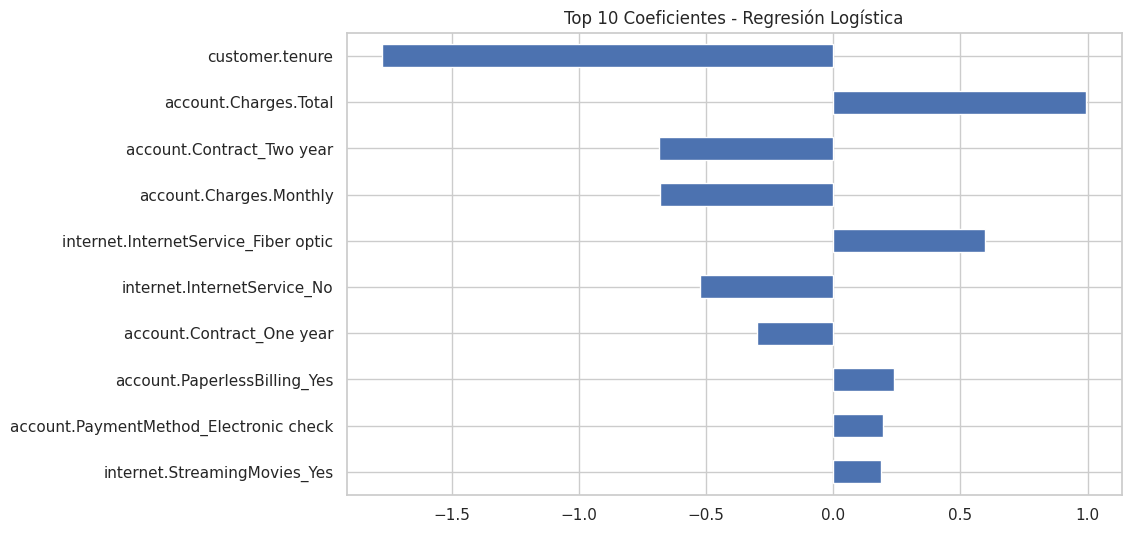

In [15]:
# =========================================================
#  Interpretación: importancia/coefs (variables más relevantes)
# =========================================================
feature_names = X.columns.tolist()

# Importancias RF
rf_importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop 10 variables (Random Forest):")
print('_______________________________________\n')
print(rf_importances.head(10))

plt.figure()
rf_importances.head(10).plot(kind='barh')
plt.title("Top 10 Importancias - Random Forest")
plt.gca().invert_yaxis()
plt.show()

# Coeficientes LR (en escala estandarizada)
lr_coefs = pd.Series(lr.coef_[0], index=feature_names)
lr_abs = lr_coefs.abs().sort_values(ascending=False)
print('\n')
print("\nTop 10 coeficientes absolutos (Regresión Logística):")
print('____________________________________________________\n')
print(lr_abs.head(10))

plt.figure()
lr_coefs[lr_abs.head(10).index].plot(kind='barh')
print('\n')
plt.title("Top 10 Coeficientes - Regresión Logística")
plt.gca().invert_yaxis()
plt.show()

<Figure size 1000x600 with 0 Axes>

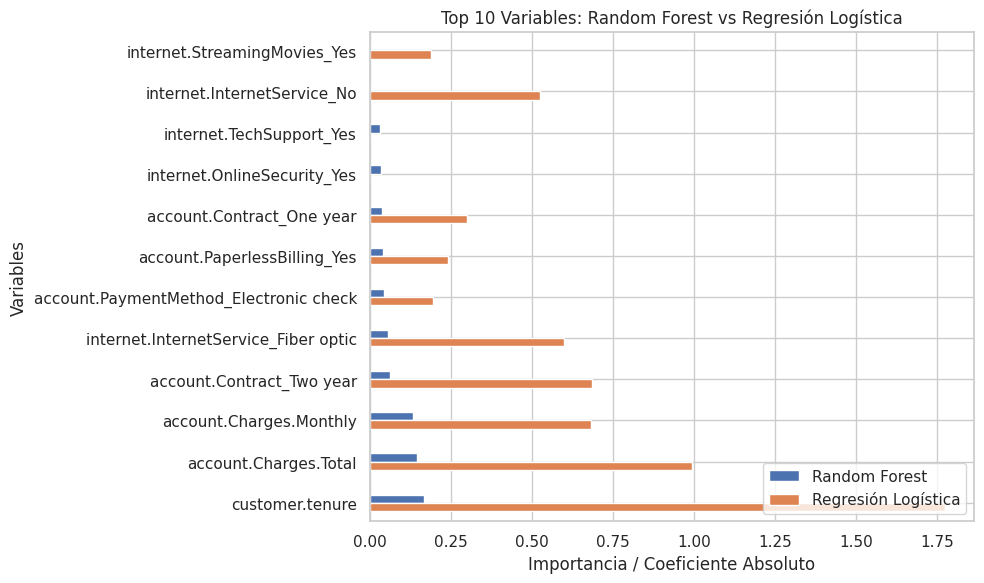

In [16]:
# Crear DataFrame comparativo
rf_top10 = rf_importances.head(10)
lr_top10 = lr_abs.head(10)

# Unir ambos en un DataFrame
df_compare = pd.DataFrame({
    'Random Forest': rf_top10,
    'Regresión Logística': lr_top10
}).fillna(0)  # rellenar con 0 donde falten variables

# Ordenar por Random Forest
df_compare = df_compare.sort_values(by='Random Forest', ascending=True)

# Gráfico de barras horizontal
plt.figure(figsize=(10,6))
df_compare.plot(kind='barh', width=0.4)
plt.title('Top 10 Variables: Random Forest vs Regresión Logística')
plt.xlabel('Importancia / Coeficiente Absoluto')
plt.ylabel('Variables')
plt.gca().invert_yaxis()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Analisis/interpretacion
**Interpretación de modelos: variables más relevantes**

La interpretación de los modelos se realizó analizando las importancias de características en el caso de Random Forest y los coeficientes en la Regresión Logística.

####1. Random Forest – Importancias de variables

El modelo de Random Forest indicó que las variables más influyentes en la predicción de la fuga de clientes son:

      1. customer.tenure (tiempo de permanencia) – 0.167

      2. account.Charges.Total (cargos totales) – 0.144

      3. account.Charges.Monthly (cargos mensuales) – 0.133

      4. account.Contract_Two year (contrato de dos años) – 0.062

      5. internet.InternetService_Fiber optic – 0.055

      6. account.PaymentMethod_Electronic check – 0.043

      7. account.PaperlessBilling_Yes – 0.041

      8. account.Contract_One year – 0.038

      9. internet.OnlineSecurity_Yes – 0.033

      10. internet.TechSupport_Yes – 0.031

* Estas variables muestran que la antigüedad del cliente, los cargos mensuales y totales, así como el tipo de contrato y los servicios de internet son determinantes en la fuga de clientes.

####2. Regresión Logística – Coeficientes absolutos

El análisis de los coeficientes estandarizados de la Regresión Logística destacó como variables más relevantes:

  1. customer.tenure – 1.776

  2. account.Charges.Total – 0.995

  3. account.Contract_Two year – 0.685

  4. account.Charges.Monthly – 0.683

  5. internet.InternetService_Fiber optic – 0.598

  6. internet.InternetService_No – 0.526

  7. account.Contract_One year – 0.300

  8. account.PaperlessBilling_Yes – 0.239

  9. account.PaymentMethod_Electronic check – 0.194

  10. internet.StreamingMovies_Yes – 0.187

* Se observa una coincidencia con el Random Forest en la relevancia de la antigüedad, los cargos y los contratos. Además, la regresión logística resalta la importancia de la no contratación de Internet y la suscripción a streaming como indicadores.

**Conclusión**

* Ambos modelos coinciden en que:

    * Mayor tiempo de permanencia reduce la probabilidad de fuga.

    * Cargos altos (mensuales o totales) se asocian con mayor riesgo de churn.

    * El tipo de contrato (dos años o un año) es un factor clave de retención.

* Servicios de Internet (fibra óptica, seguridad en línea, soporte técnico) también son altamente relevantes para explicar la permanencia o salida del cliente.

* Los gráficos generados muestran visualmente el ranking de importancia de las variables, lo que facilita priorizar acciones de retención enfocadas en contratos, cargos y servicios de Internet.

##9. Conclusion estratégica breve basada en importancia
- Factores con mayor impacto (RF): customer.tenure, account.Charges.Total, account.Charges.Monthly, account.Contract_Two year, internet.InternetService_Fiber optic
- Factores con mayor peso (LR): customer.tenure, account.Charges.Total, account.Contract_Two year, account.Charges.Monthly, internet.InternetService_Fiber optic
- Recomendación: priorizar retención en clientes con menor tenure y mayor cargo total/mensual; revisar contratos mes a mes y métodos de pago asociados si aparecen como relevantes.

#10. Informe Fuga Clientes Empresa Telecom X Parte 2 — Análisis Global y Conclusiones

##Preparación de datos

- La proporción de Churn es de 26,5% para clientes que abandonan y 73,5% para los que permanecen. Esto indica un dataset moderadamente desbalanceado, lo que justifica el uso de técnicas como SMOTE más adelante.

- La preparación de datos eliminó columnas irrelevantes y estableció un target binario, asegurando calidad y coherencia en el dataset.

- **Insight**: existe una base suficiente de clientes churn para modelar, pero el desbalance podría afectar la sensibilidad de los modelos.

##Codificación de variables categóricas

- Se utilizó get_dummies para variables categóricas, permitiendo que los modelos numéricos procesen correctamente los datos.

- El tratamiento de variables de internet asegura que los distintos tipos de servicio se consideren de forma consistente.

- **Insight**: todas las variables categóricas relevantes ahora pueden ser interpretadas por los modelos sin perder información significativa.

##Correlación y visualización

- Las variables con mayor correlación absoluta con Churn son customer.tenure (0.352) e indicadores de servicios y contratos (InternetService_Fiber optic, Contract_Two year, PaymentMethod_Electronic check).

- Los resúmenes estadísticos muestran que los clientes que churn tienen **tenure menor (17.97 vs 37.57 meses) y cargos totales y mensuales menores en promedio** que los que no churn.
Esto indica que la permanencia más corta y ciertos patrones de consumo están asociados con mayor probabilidad de churn.
- **Insight**: la permanencia corta y ciertos tipos de servicios y contratos son predictores clave de abandono.

##Balanceo y normalización

- Se aplicó **SMOTE**, equilibrando la clase minoritaria Churn=1 de 1.308 a 3.622 muestras. Esto previene que los modelos sesguen hacia la clase mayoritaria.

- Las variables numéricas fueron normalizadas/estandarizadas, permitiendo un entrenamiento adecuado de modelos sensibles a la escala como regresión logística.

| Clase | Original | Post-SMOTE |
|-------|----------|------------|
| 0 | 3622 | 3622 |
| 1 | 1308 | 3622 |


- **Insight**: el modelo ahora puede aprender patrones de churn sin sesgo hacia la clase mayoritaria.

##Modelado predictivo

- Se entrenaron **Regresión Logística** (requiere escala) y **Random Forest** (no requiere escala).

- Ambos modelos están preparados para evaluar la probabilidad de churn, con Random Forest capturando relaciones no lineales y la regresión logística permitiendo interpretación de coeficientes.
- **Insight**: se dispone de modelos que permiten tanto interpretación (logística) como detección de relaciones complejas (Random Forest).

##Evaluación de modelos

| Métrica | Regresión Logística | Random Forest |
|---------|-------------------|---------------|
| Accuracy | 0.746 | 0.776 |
| Precision (Churn) | 0.514 | 0.575 |
| Recall (Churn) | 0.795 | 0.595 |
| F1-score | 0.625 | 0.585 |
| AUC | 0.84 | 0.82 |


- **Regresión Logística:** Accuracy 0.746, Precision 0.514, Recall 0.795 (alta sensibilidad para churn), F1 0.625.

Fuerte capacidad de identificar churns (recall alto), pero precisión moderada, lo que indica falsos positivos.

- **Random Forest:** Accuracy 0.776, Precision 0.575, Recall 0.595, F1 0.585. Mejor equilibrio entre precisión y recall, mayor exactitud general, robusto ante relaciones complejas.

- La elección del modelo depende de priorizar: detección de churn (regresión logística) o balance general de métricas (Random Forest).

- **Insight**: para detectar la mayoría de clientes que podrían abandonar, la regresión logística es más adecuada; para decisiones balanceadas y robustas, Random Forest es preferible.

##Interpretación de importancia de variables

Ambos modelos coinciden en que las variables más relevantes son:

- customer.tenure (más influyente)

- account.Charges.Total y account.Charges.Monthly

- Tipo de contrato y servicios de internet.

- La evidencia numérica indica que **clientes con menor tenure y menor gasto mensual/total tienen mayor probabilidad de churn.**

- Variables como métodos de pago electrónicos y paperless billing tienen impacto moderado, útiles para segmentación de clientes.

- **Insight**: clientes nuevos o con baja permanencia y menor gasto son los más propensos a churn; servicios y métodos de pago influyen moderadamente.

##Conclusiones

**1. Perfil de riesgo de churn:** Clientes con menor antigüedad (tenure), cargos más bajos y ciertos tipos de contrato/servicios son los más propensos a abandonar.

**2. Estrategias de retención:** Intervenciones dirigidas a clientes nuevos o con baja permanencia, ajustes en planes de servicios y métodos de pago, podrían reducir el churn.

**3. Selección de modelo:** Para detectar la mayor cantidad de churns se recomienda **regresión logística**, mientras que para balance general de predicción y robustez frente a relaciones complejas, **Random Forest** es más adecuado.

**4. Reproducibilidad y análisis:** Los pasos de preparación, balanceo y normalización garantizan que los modelos sean consistentes y que los insights estén basados en datos reales, no suposiciones.

##Resumen:

El análisis de los datos reales de la empresa demuestra que la combinación de variables de tenure, cargos y contratos permite predecir churn con métricas razonables.

Las decisiones estratégicas deben apoyarse en estos hallazgos para priorizar retención y optimizar recursos.